# Bagging Demo

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In this lab we'll use the customer churn data from before. We'll use the preprocessed version, even though this is actually not necessary for the bagging method since scaling does not influence the restults as in knn.

In [2]:
df = pd.read_csv("./data/churndata_processed.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   months                     7043 non-null   float64
 1   multiple                   7043 non-null   int64  
 2   gb_mon                     7043 non-null   float64
 3   security                   7043 non-null   int64  
 4   backup                     7043 non-null   int64  
 5   protection                 7043 non-null   int64  
 6   support                    7043 non-null   int64  
 7   unlimited                  7043 non-null   int64  
 8   contract                   7043 non-null   float64
 9   paperless                  7043 non-null   int64  
 10  monthly                    7043 non-null   float64
 11  satisfaction               7043 non-null   float64
 12  churn_value                7043 non-null   int64  
 13  payment_Credit Card        7043 non-null   int64

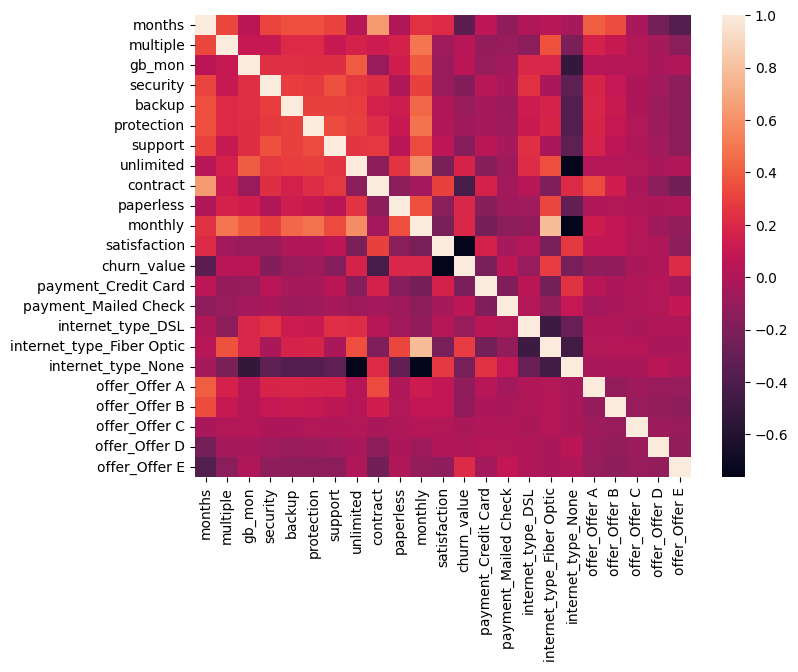

In [4]:
fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(df.corr());

## Preprocessing

- Splitting train/test
- Taking into account unbalanced classes

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

target = 'churn_value'
features = df.drop(columns=[target]).columns

X = df[features]
y = df[target]

sss = StratifiedShuffleSplit(n_splits=1, test_size=1500, random_state=42)
train_idx, test_idx = next(sss.split(df[features], df[target]))

# Create the data sets
X_train = X.loc[train_idx]
y_train = y.loc[train_idx]

X_test = X.loc[test_idx]
y_test = y.loc[test_idx]

## Random Forest and OOB-error

We'll fit different randomForest models where the only difference is the number of trees. Then we explore the OOB (out-of-bag) - Error as function of the number of trees.

Afterwards we can see the error stabilise for a specific number of trees; adding more trees does not improve the model in a meaningful way.

In [13]:
# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Use OOB score, use warm_start for optimization reasons, we'll set the number of trees later
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = []

for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    RF.set_params(n_estimators=n_trees)
    RF.fit(X_train, y_train)
    oob_error = 1 - RF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

,oob
n_trees,
15.0,0.055566
20.0,0.052138
30.0,0.049973
40.0,0.048890
50.0,0.049071
100.0,0.047447
150.0,0.046726
200.0,0.047447
300.0,0.047988


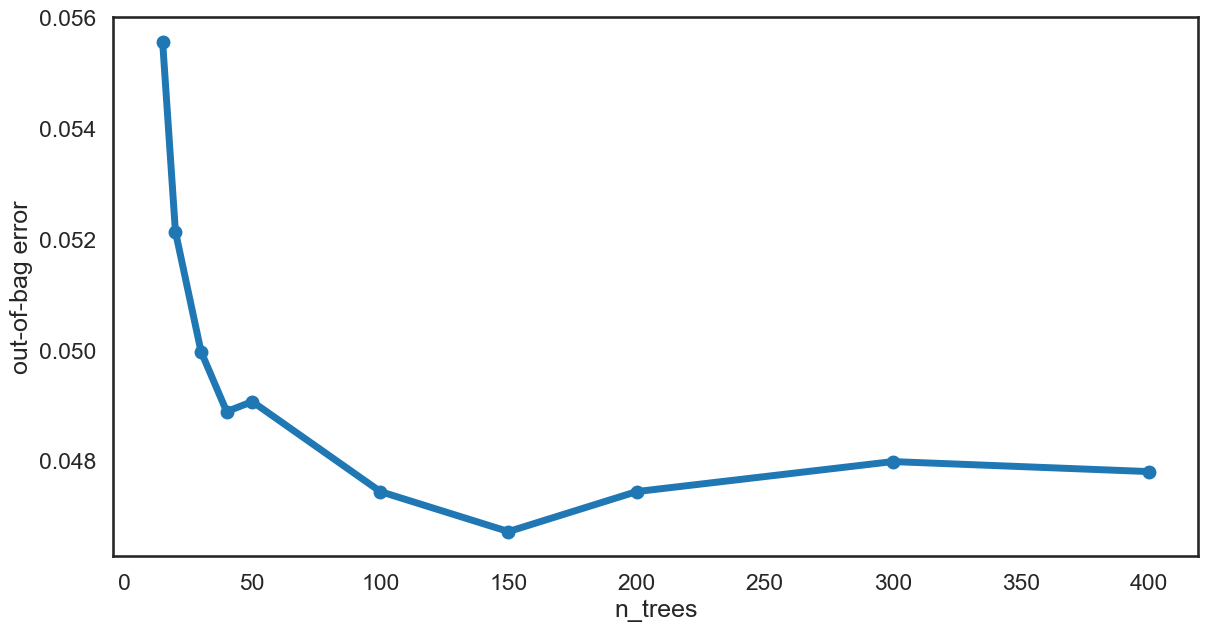

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

## ExtraTrees

We can also take ExtraTrees to fit the model in the same way. However, we will see that in this case the RandomForest performs better. The additional randomization does not improve model performance.

In [16]:
from sklearn.ensemble import ExtraTreesClassifier

EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = []

for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    EF.set_params(n_estimators=n_trees)
    EF.fit(X_train, y_train)

    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')
et_oob_df

,oob
n_trees,
15.0,0.066570
20.0,0.063864
30.0,0.057550
40.0,0.053942
50.0,0.052318
100.0,0.051236
150.0,0.048890
200.0,0.048530
300.0,0.049612


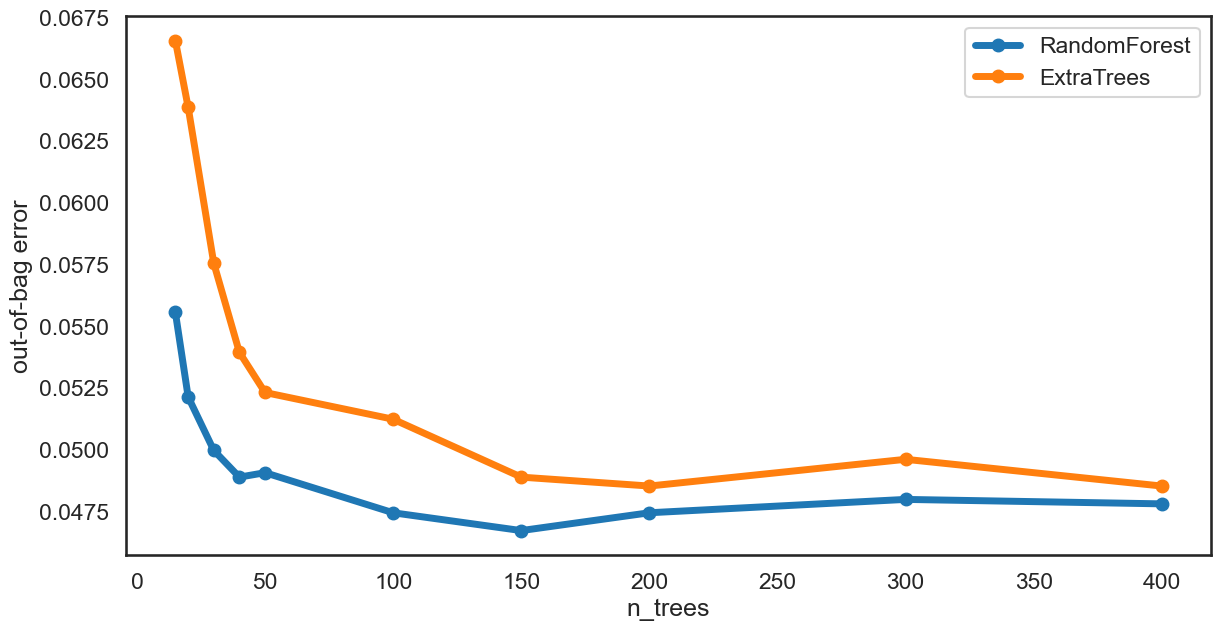

In [18]:
oob_df = pd.concat([rf_oob_df.rename(columns={'oob':'RandomForest'}),
                    et_oob_df.rename(columns={'oob':'ExtraTrees'})], axis=1)

sns.set_context('talk')
sns.set_style('white')

ax = oob_df.plot(marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

## Results

In [19]:
model = RF.set_params(n_estimators=100)
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1102
           1       0.94      0.83      0.88       398

    accuracy                           0.94      1500
   macro avg       0.94      0.90      0.92      1500
weighted avg       0.94      0.94      0.94      1500

   accuracy  precision    recall    f1       auc
0      0.94     0.9375  0.829146  0.88  0.904591


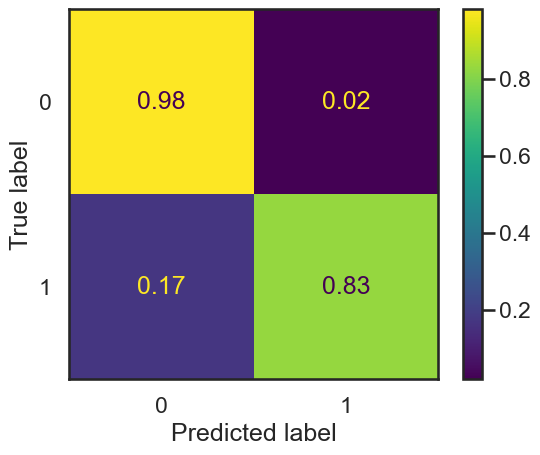

In [20]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix,ConfusionMatrixDisplay

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()

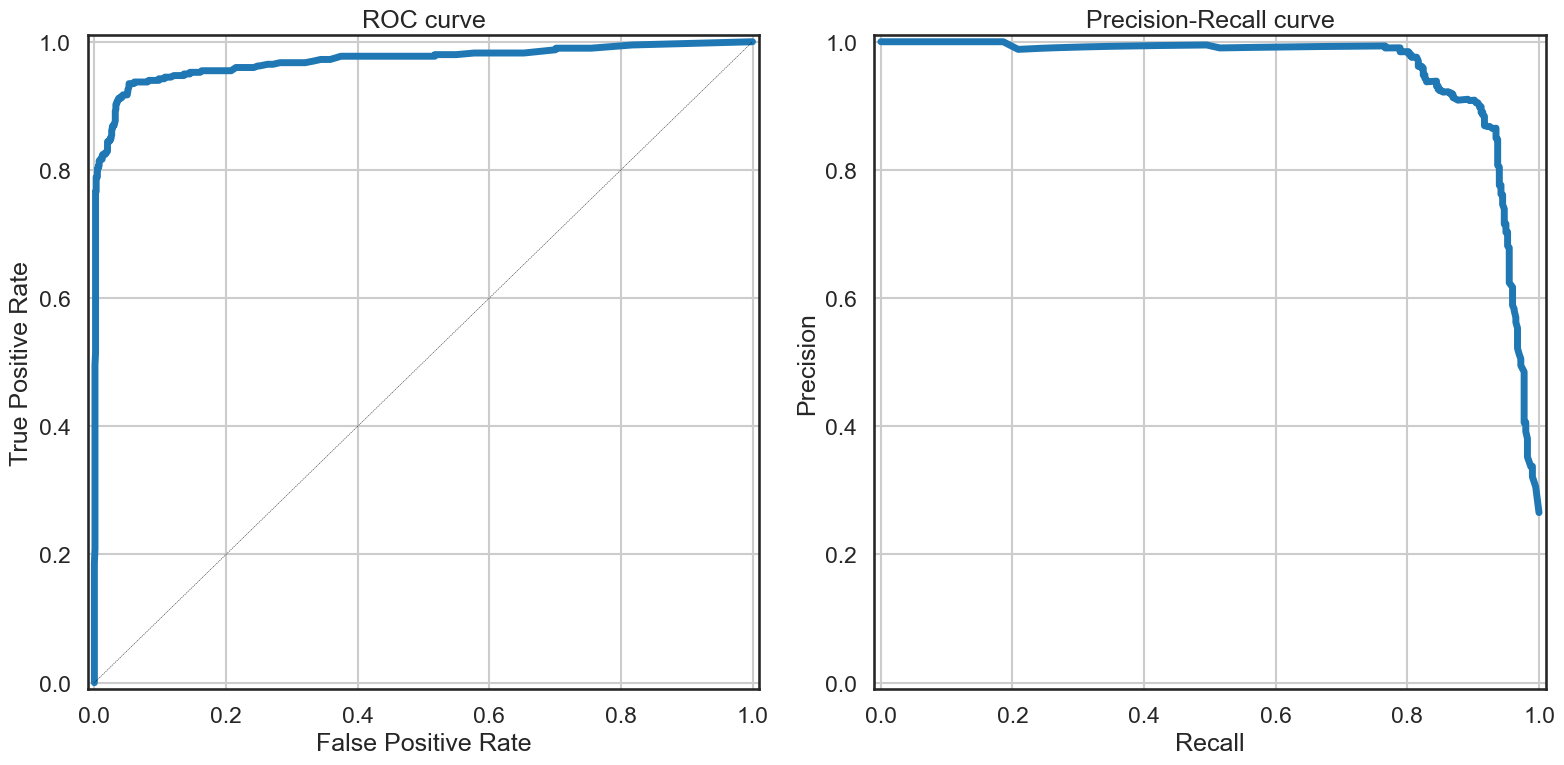

In [21]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr, linewidth=5)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision, linewidth=5)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

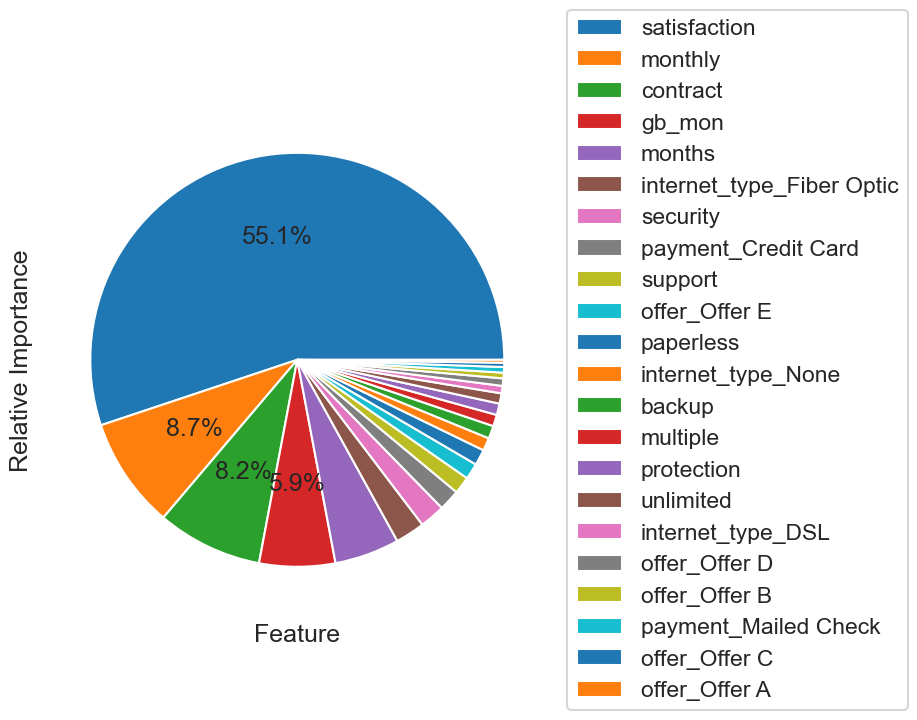

In [22]:
feature_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(16, 6))
ax.pie(feature_imp, labels=None, autopct=lambda pct: '{:1.1f}%'.format(pct) if pct > 5.5 else '')
ax.set(ylabel='Relative Importance')
ax.set(xlabel='Feature')

# Adjust the layout to prevent label overlapping
plt.tight_layout()

# Move the legend outside the chart
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),labels=feature_imp.index)

plt.show()